# initial data exploration


In [1]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import matplotlib.ticker as ticker 
from sklearn.cluster import KMeans
from datetime import datetime
from pytz import timezone

In [2]:
connection = sqlalchemy.create_engine("postgresql://tcosse:mysecretpassword@db_container:5432/piscineds")

In [3]:
data = pd.read_sql_query("SELECT event_time, user_id, price, user_session from customers where event_type = 'purchase'", con=connection)

In [4]:
data = pd.DataFrame(data, columns=['event_time', 'user_id'])


print(data['event_time'])

0         2023-01-16 07:45:21+00:00
1         2023-01-15 14:36:23+00:00
2         2023-01-20 13:49:41+00:00
3         2023-01-21 19:58:12+00:00
4         2023-01-23 18:54:18+00:00
                     ...           
1044211   2023-01-31 20:01:19+00:00
1044212   2023-01-31 14:19:45+00:00
1044213   2023-01-29 14:07:44+00:00
1044214   2023-01-31 14:19:45+00:00
1044215   2023-01-30 13:31:13+00:00
Name: event_time, Length: 1044216, dtype: datetime64[ns, UTC]


In [5]:
customers_data = {
    'platinum': [],
    'gold': [],
    'silver': [],
    'newCustomer': [],
    'inactive': []
}

def TrimCustomer(custo):
    nb_purchase = custo['event_time'].count()
    
    if max(custo['event_time']) <= pd.Timestamp("2022-10-25 00:00:00",tz='UTC'):
        customers_data['inactive'].append([nb_purchase ,(pd.Timestamp("2023-02-15 00:00:00",tz='UTC') - max(custo['event_time'])).days // 30])
    elif (nb_purchase <= 9):
        if max(custo['event_time']) >= pd.Timestamp("2023-01-01 00:00:00",tz='UTC'):
            customers_data['newCustomer'].append([nb_purchase ,(pd.Timestamp("2023-02-15 00:00:00",tz='UTC') - max(custo['event_time'])).days // 30])
        else:
            customers_data['silver'].append([nb_purchase ,(pd.Timestamp("2023-02-15 00:00:00",tz='UTC') - max(custo['event_time'])).days // 30])
    elif (nb_purchase > 9 and nb_purchase <= 12):
        customers_data['gold'].append([nb_purchase ,(pd.Timestamp("2023-02-15 00:00:00",tz='UTC') - max(custo['event_time'])).days // 30])
    elif (nb_purchase > 12):
        customers_data['platinum'].append([nb_purchase ,(pd.Timestamp("2023-02-15 00:00:00",tz='UTC') - max(custo['event_time'])).days // 30])

number_of_value = data['user_id'].count()

data.groupby(['user_id']).apply(TrimCustomer)

""


In [6]:
general_cluster = {
    'loyal': len(customers_data['platinum']) + len(customers_data['gold']) + len(customers_data['silver']),
    'inactive': len(customers_data['inactive']),
    'newCustomer': len(customers_data['newCustomer'])
}
print(general_cluster)

kmeans = KMeans(3, random_state=42)
data = list(general_cluster.items())
general_cluster = np.array([[row[1]] for row in data])
pred = kmeans.fit_predict(general_cluster)

{'loyal': 62116, 'inactive': 14470, 'newCustomer': 16066}


/usr/local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


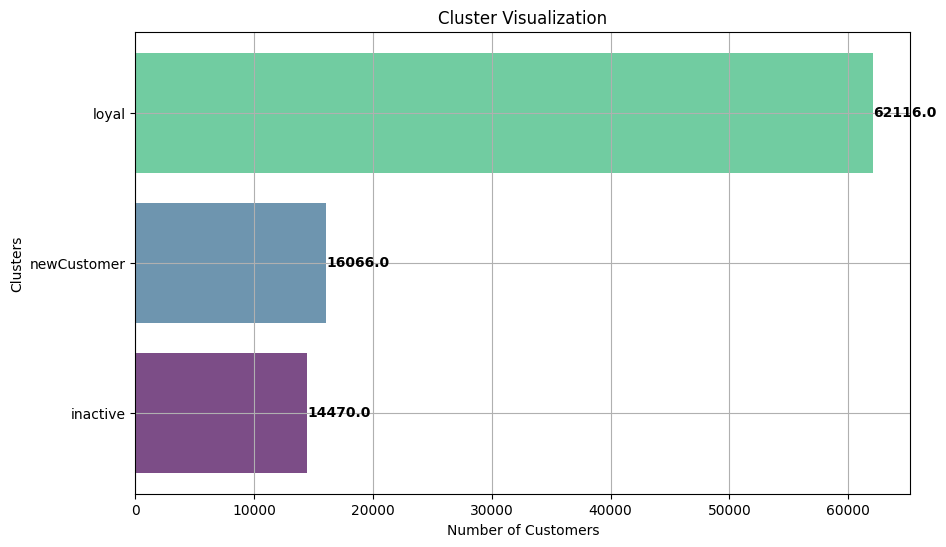

In [7]:
group_names = {
        1: "loyal",
        2: 'newCustomer',
        0: "inactive"
}

cluster_averages = []
for i in range(3):
    cluster_points = np.array([data[j][1] for j in range(len(data)) if pred[j] == i])
    cluster_averages.append(np.mean(cluster_points))
sorted_indices = np.argsort(cluster_averages)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(sorted_indices):
    cluster_points = np.array([data[j][1] for j in range(len(data)) if pred[j] == idx])
    color = plt.cm.viridis(i / 3)
    plt.barh(i, np.mean(cluster_points), color=color, alpha=0.7)
    plt.text(np.mean(cluster_points) + 0.8, i, f'{cluster_averages[idx]}', ha='left', va='center', fontsize=10, color='black', weight='bold')

plt.ylabel("Clusters")
plt.xlabel("Number of Customers")
plt.title("Cluster Visualization")
plt.yticks(range(3), [group_names[idx] for idx in sorted_indices])
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single el

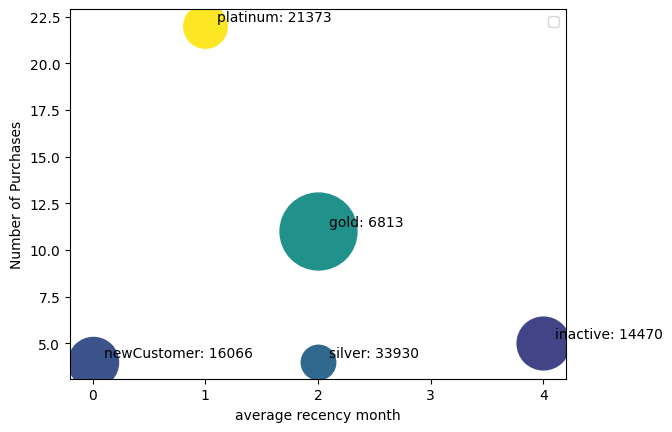

In [8]:
group_names = {
        0: "new customer",
        2: "inactive",
        1: 'platinum',
        3: 'gold',
        4: 'silver',
}

i = 1
point = []

for name in customers_data:
        points = list(zip(*customers_data[name]))
        pointSize = 2000 * (number_of_value / len(customers_data[name])) / 100
        x = pd.DataFrame(points[1]).median()
        y = pd.DataFrame(points[0]).median()
        color = plt.cm.viridis(1 / i)
        i += 1
        plt.scatter(x, y, color=color, s=pointSize)
        plt.annotate(name + ': ' + str(len(customers_data[name])), (x + 0.1, y + 0.25))



plt.xlabel("average recency month")
plt.xticks(range(5))
plt.ylabel("Number of Purchases")
plt.legend()
plt.grid(False)
plt.show()